# MSE 546 Project
### Bank Customer Churn Prediction 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import torch

seed = 7530

# load data

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.shape)
print(df_test.shape)

df_train.head(5)

(165034, 14)
(110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [73]:
df_train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

# EDA

plot correlation matrix to see if there's any multicolinearity between features

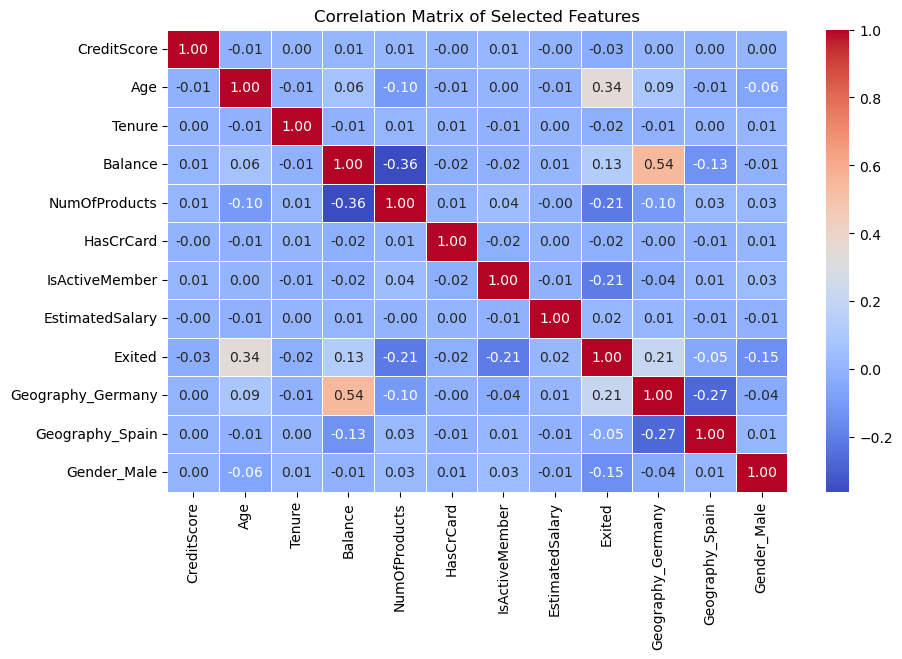

In [4]:
features = [
    "CreditScore", 
    "Geography", 
    "Gender", 
    "Age", 
    "Tenure", 
    "Balance", 
    "NumOfProducts", 
    "HasCrCard", 
    "IsActiveMember", 
    "EstimatedSalary",
      "Exited"
]

df_encoded = pd.get_dummies(df_train[features], drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

boxplot of all features to compare Exited customers to non Exited.

Inisghts:
- customers Exited are older on average

In [5]:
exclude_columns = ['CustomerId', 'id', 'Surname'] 
feature_columns = [col for col in df_train.columns if col not in exclude_columns]
print(feature_columns)
categorical_features = df_train[feature_columns].select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_features)
numerical_features = df_train[feature_columns].select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
['Geography', 'Gender']
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [6]:
category_percentages = {}

for col in categorical_features:
    category_percentages[col] = {}
    
    # Get the count of occurrences for each combination of category and Exited value (0 or 1)
    category_counts = df_train.groupby([col, 'Exited']).size().unstack(fill_value=0)
    
    for category in category_counts.index:
        total_count = category_counts.loc[category].sum()
        percentage_1 = (category_counts.loc[category, 1] / total_count) * 100 if total_count > 0 else 0
        percentage_0 = (category_counts.loc[category, 0] / total_count) * 100 if total_count > 0 else 0
        category_percentages[col][category] = {'percentage_1': percentage_1, 'percentage_0': percentage_0}

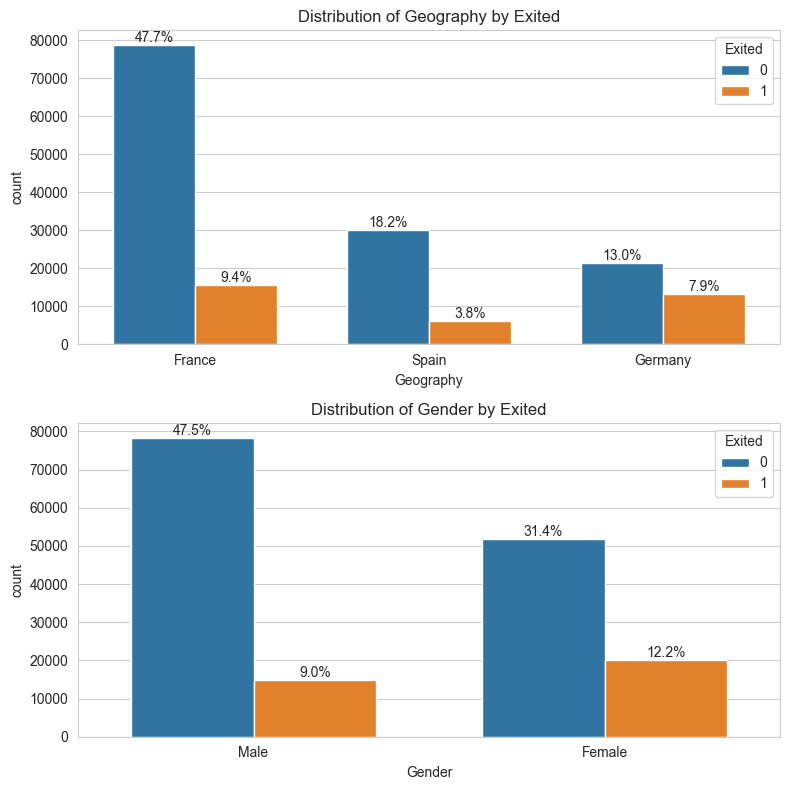

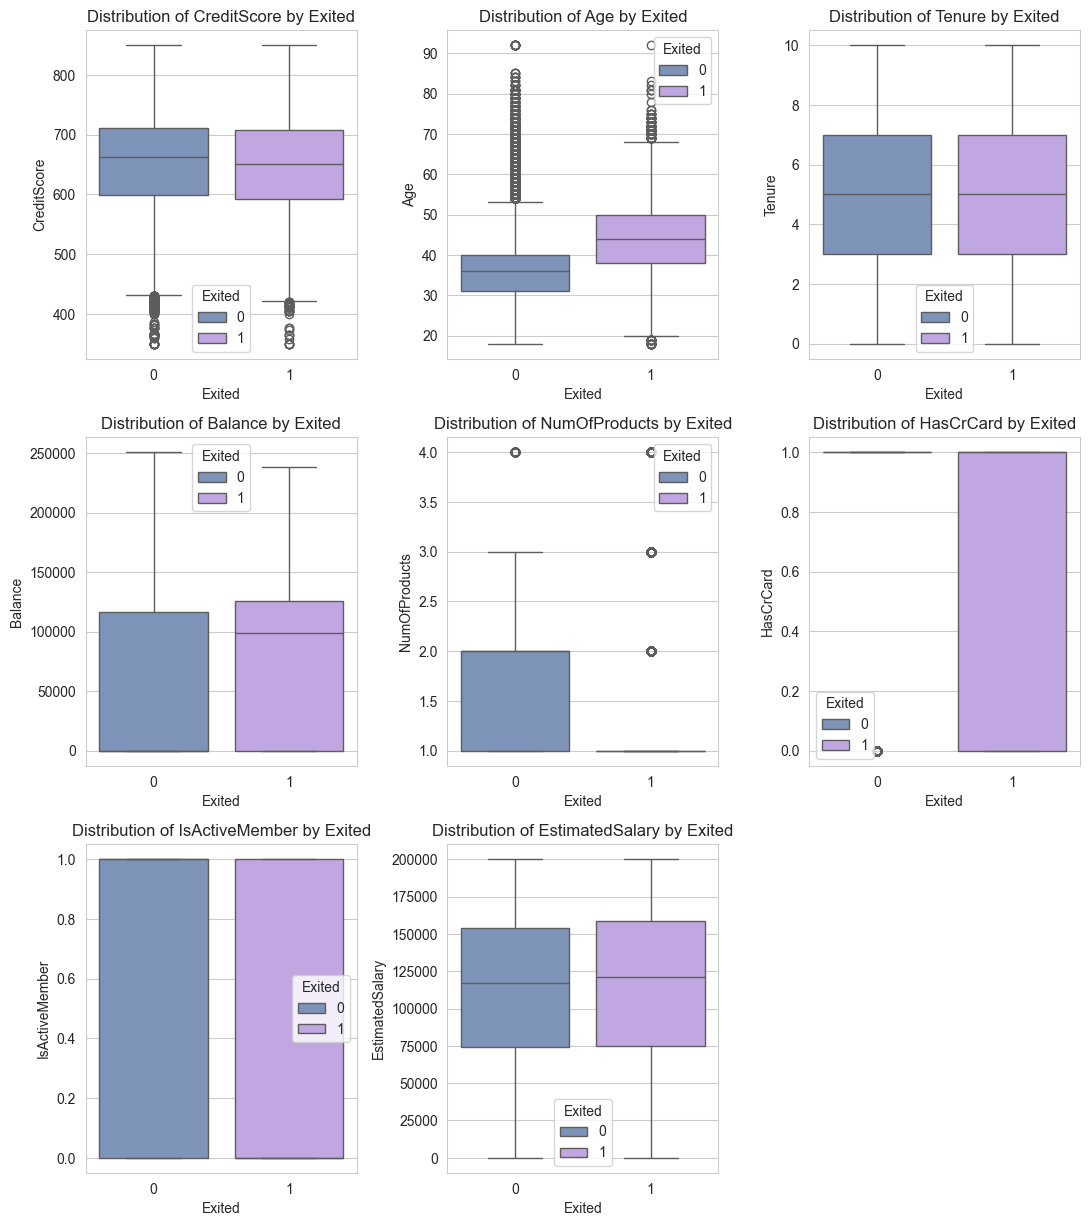

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4 * len(categorical_features))) 

for i, col in enumerate(categorical_features, 1):
    plt.subplot(len(categorical_features), 1, i)
    
    ax = sns.countplot(data=df_train[feature_columns], x=col, hue='Exited', width = 0.7)
    plt.title(f"Distribution of {col} by {'Exited'}")
    
    for p in ax.patches:
        height = p.get_height() 
        total = len(df_train[feature_columns])  # Total number of entries in the selected column
        percentage = (height / total) * 100

        # Only add annotation if the height (count) is greater than 0
        if height > 0:
            ax.annotate(f'{percentage:.1f}%',   
                        (p.get_x() + p.get_width() / 2., height),  # Positioning of the text
                        ha='center', va='center', 
                        xytext=(0, 5),  # Offset to move the label up a bit
                        textcoords='offset points')

    # Iterate over each categorical feature
    # Get the x-axis positions (category labels) from the bar chart
    categories = ax.get_xticks()  # This gives you the positions of the categories on the x-axis
    category_labels = ax.get_xticklabels()  # This gives you the actual labels of the categories
    
plt.tight_layout()
plt.show()

num_cols = 3
num_rows = (len(numerical_features) // num_cols + 1)

plt.figure(figsize=(11, 4 * num_rows))
custom_palette = ["#7490C2", "#C09EEA"]

for i, col in enumerate(numerical_features, 1):
    if col != 'Exited':
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(data=df_train[feature_columns], x='Exited', y=col,  hue='Exited', palette=custom_palette)
        plt.title(f"Distribution of {col} by {'Exited'}")
plt.tight_layout()
plt.show()

# class imbalance

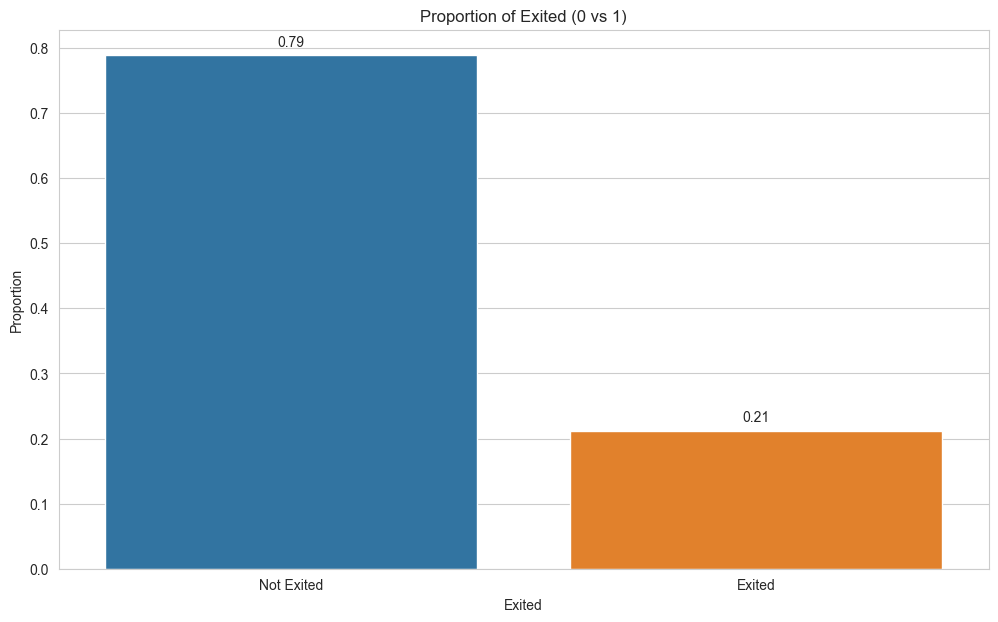

In [5]:
exited_proportion = df_train['Exited'].value_counts(normalize=True)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=exited_proportion.index, y=exited_proportion.values, hue=exited_proportion.index, legend=False)
plt.title('Proportion of Exited (0 vs 1)')
plt.xlabel('Exited')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Not Exited', 'Exited'])

for i, proportion in enumerate(exited_proportion.values):
    ax.text(i, proportion + 0.01, f'{proportion:.2f}', ha='center', va='bottom')

plt.show()

# data cleaning

In [7]:
def clean(df):
    df = df.dropna()
    df = df.drop_duplicates()
    return df

df_train = clean(df_train)
df_test = clean(df_test)
print(df_train.shape)

(165034, 14)


# data preparation

here we are performing the 80%/20% train test split on our df_train dataframe since we only have 'Exited' labels on the train.csv. The test.csv data does not have 'Exited' flag, but instead will be submitted to the Kaggle competition to see model performance.

The scikit learn pipeline allows us to perform our data preprocessing on our numeric and categorical variables consistently for all of our models.

- numeric features: will be scaled.

    - numeric features include:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

- categorical variables will be one hot encoded.

    - categorical features include:
['Geography', 'Gender']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(columns=['id', 'CustomerId', 'Surname', 'Exited']),
    df_train['Exited'],
    test_size=0.2,
    random_state=seed
)

num_features = X_train.select_dtypes(include=['int64', 'float64', 'boolean']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
])

# cross validation code

here we have code that will be applied to the models to evaulate the generalizability

we're using stratified sampling since we have imbalanced classes. This will help to ensure that each of our partitions will have around the same proportion of each class. (i.e., we won't get a partition with all the majority class 'Exited' = 0)

In [9]:
def perform_x_validation(model, folds=5):
    scoring = {
        'auc': 'roc_auc',
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }

    num_folds = 5
    res = cross_validate(model, X_train, y_train, cv=num_folds, scoring=scoring)

    for fold in range(num_folds):
        print(f"Fold {fold + 1}:")
        print(f"AUC: {res['test_auc'][fold]:.4f}")
        print(f"Accuracy: {res['test_accuracy'][fold]:.4f}")
        print(f"Precision: {res['test_precision'][fold]:.4f}")
        print(f"Recall: {res['test_recall'][fold]:.4f}")
        print(f"F1 Score: {res['test_f1'][fold]:.4f}")
        print()

    print("mean:")
    print(f"AUC: {res['test_auc'].mean():.4f}")
    print(f"accuracy: {res['test_accuracy'].mean():.4f}")
    print(f"precision: {res['test_precision'].mean():.4f}")
    print(f"recall: {res['test_recall'].mean():.4f}")
    print(f"F1 score: {res['test_f1'].mean():.4f}")

# model evaluation code

this code will be used to evaulate our models to do the model selection process.

includes key metrics like Accuracy, precision, recall, F1 score, and AUC (most important)

we will also plot a confusion matrix to view the models predictions compared to actual churn

In [10]:
def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_custom = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred_custom))
    print(classification_report(y_test, y_pred_custom))

    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # plot confusion matrix
    # ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    # ref: https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
    # ref: https://seaborn.pydata.org/generated/seaborn.heatmap.html

    cm = confusion_matrix(y_test, y_pred_custom)

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Not Churn', 'Predicted Churn'], 
                yticklabels=['Actual Not Churn', 'Actual Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

    # plot the area under the ROC curve
    # ref: https://www.w3schools.com/python/python_ml_auc_roc.asp
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, auc

In [11]:
# Initialize dictionaries to store results for overall AUC plot
fpr_dict_base = {}
tpr_dict_base = {}
auc_dict_base = {}

fpr_dict = {}
tpr_dict = {}
auc_dict = {}


# logistic regression

### baseline

C:\Users\gabby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7010028175841488
              precision    recall  f1-score   support

           0       0.89      0.70      0.79     25915
           1       0.39      0.69      0.50      7092

    accuracy                           0.70     33007
   macro avg       0.64      0.70      0.64     33007
weighted avg       0.78      0.70      0.72     33007

Precision: 0.3891
Recall: 0.6873
F1 Score: 0.4969
AUC: 0.7518


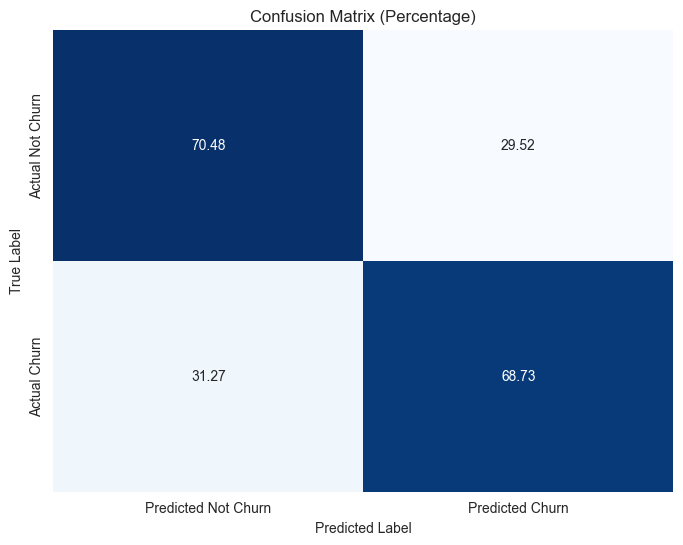

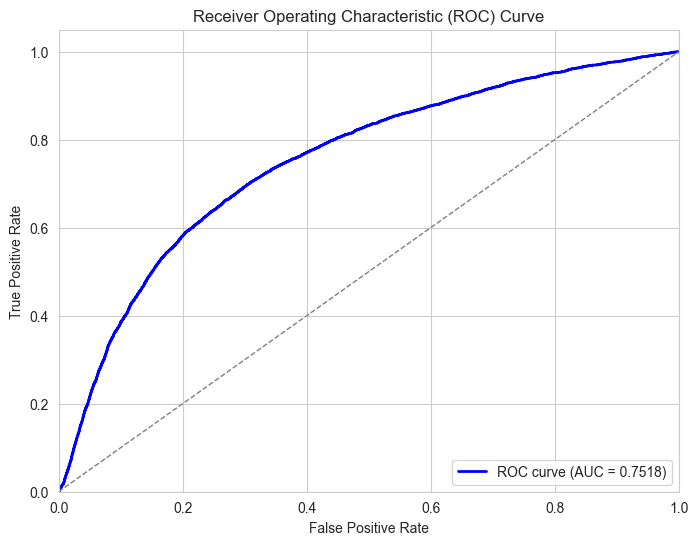

C:\Users\gabby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gabby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Fold 1:
AUC: 0.7497
Accuracy: 0.6982
Precision: 0.7851
Recall: 0.6982
F1 Score: 0.7233

Fold 2:
AUC: 0.7455
Accuracy: 0.7037
Precision: 0.7810
Recall: 0.7037
F1 Score: 0.7272

Fold 3:
AUC: 0.7451
Accuracy: 0.6897
Precision: 0.7805
Recall: 0.6897
F1 Score: 0.7159

Fold 4:
AUC: 0.7832
Accuracy: 0.7285
Precision: 0.8051
Recall: 0.7285
F1 Score: 0.7503

Fold 5:
AUC: 0.7564
Accuracy: 0.6987
Precision: 0.7897
Recall: 0.6987
F1 Score: 0.7242

mean:
AUC: 0.7560
accuracy: 0.7038
precision: 0.7883
recall: 0.7038
F1 score: 0.7282


In [87]:
training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', LogisticRegression(random_state=seed))  
])
training_pipeline.fit(X_train, y_train)
basemodel_logreg = training_pipeline

fpr, tpr, auc = evaluate_model(training_pipeline, X_test, y_test)
# fpr_dict_base['Logistic Regression'] = fpr
# tpr_dict_base['Logistic Regression'] = tpr
# auc_dict_base['Logistic Regression'] = auc

fpr_dict['Logistic Regression'] = fpr
tpr_dict['Logistic Regression'] = tpr
auc_dict['Logistic Regression'] = auc

perform_x_validation(training_pipeline)

### hyperparameter tuning

C:\Users\gabby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'classifier__max_iter': 100, 'classifier__penalty': 'l1'}
Accuracy: 0.7550822552791832
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     25915
           1       0.46      0.73      0.56      7092

    accuracy                           0.76     33007
   macro avg       0.68      0.75      0.70     33007
weighted avg       0.81      0.76      0.77     33007

Precision: 0.4563
Recall: 0.7310
F1 Score: 0.5619
AUC: 0.8176


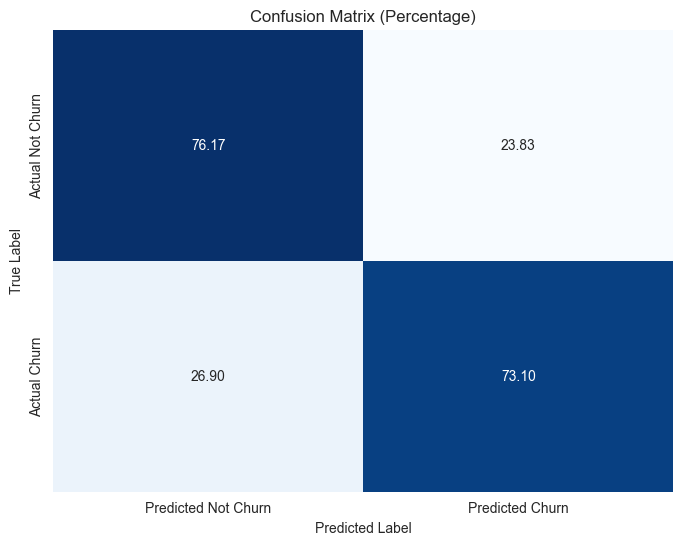

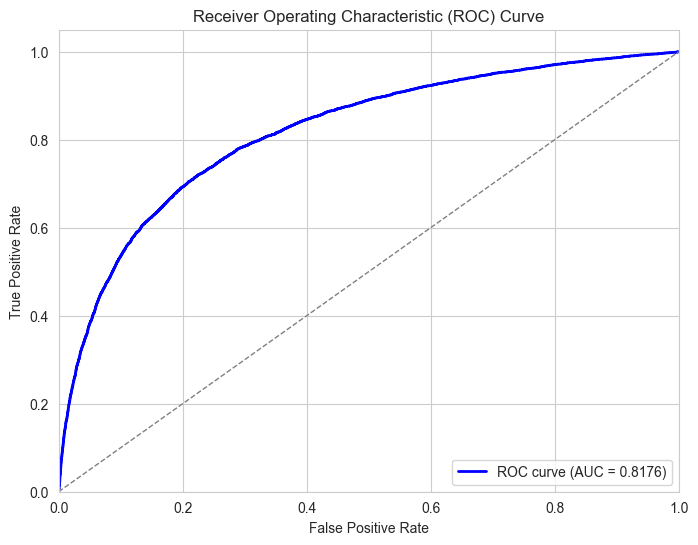

In [12]:
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [100, 200, 500, 1000]
}

training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', LogisticRegression(random_state=seed, solver='liblinear'))
])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'auc': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
}

grid_search = GridSearchCV(
    estimator=training_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
model_logreg = best_model

fpr, tpr, auc = evaluate_model(best_model, X_test, y_test)
fpr_dict['Logistic Regression'] = fpr
tpr_dict['Logistic Regression'] = tpr
auc_dict['Logistic Regression'] = auc

# decision tree

### baseline

Accuracy: 0.7267852273760111
              precision    recall  f1-score   support

           0       0.91      0.73      0.81     25915
           1       0.42      0.73      0.53      7092

    accuracy                           0.73     33007
   macro avg       0.66      0.73      0.67     33007
weighted avg       0.80      0.73      0.75     33007

Precision: 0.4216
Recall: 0.7307
F1 Score: 0.5347
AUC: 0.7282


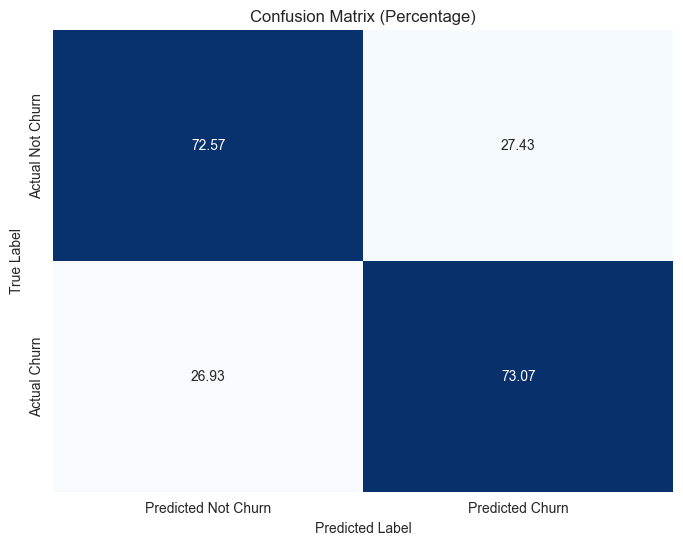

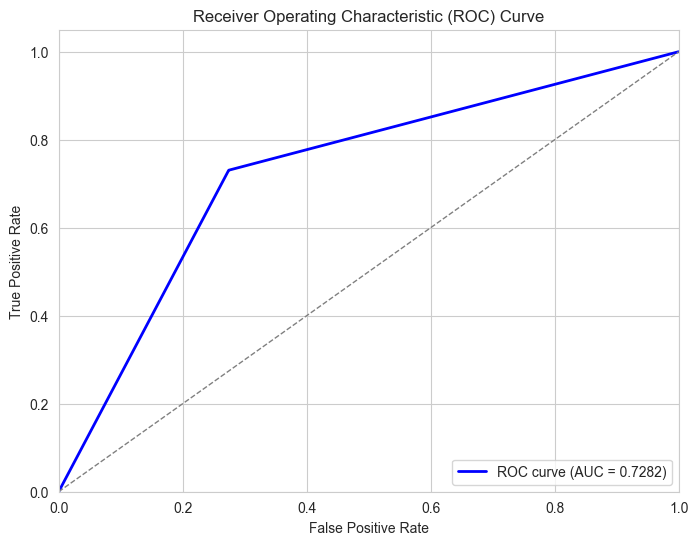

Fold 1:
AUC: 0.7232
Accuracy: 0.7246
Precision: 0.8026
Recall: 0.7246
F1 Score: 0.7468

Fold 2:
AUC: 0.7259
Accuracy: 0.7243
Precision: 0.8042
Recall: 0.7243
F1 Score: 0.7468

Fold 3:
AUC: 0.7275
Accuracy: 0.7274
Precision: 0.8053
Recall: 0.7274
F1 Score: 0.7494

Fold 4:
AUC: 0.7205
Accuracy: 0.7232
Precision: 0.8009
Recall: 0.7232
F1 Score: 0.7455

Fold 5:
AUC: 0.7220
Accuracy: 0.7221
Precision: 0.8019
Recall: 0.7221
F1 Score: 0.7447

mean:
AUC: 0.7238
accuracy: 0.7243
precision: 0.8030
recall: 0.7243
F1 score: 0.7466


In [13]:
training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

training_pipeline.fit(X_train, y_train)
basemodel_dectree = training_pipeline

fpr, tpr, auc = evaluate_model(training_pipeline, X_test, y_test)
fpr_dict_base['Decision Tree'] = fpr
tpr_dict_base['Decision Tree'] = tpr
auc_dict_base['Decision Tree'] = auc

perform_x_validation(training_pipeline)

### hyperparameter tuning

Best Hyperparameters: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Accuracy: 0.8068894476929136
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     25915
           1       0.53      0.78      0.64      7092

    accuracy                           0.81     33007
   macro avg       0.73      0.80      0.75     33007
weighted avg       0.85      0.81      0.82     33007

Precision: 0.5345
Recall: 0.7848
F1 Score: 0.6359
AUC: 0.8807


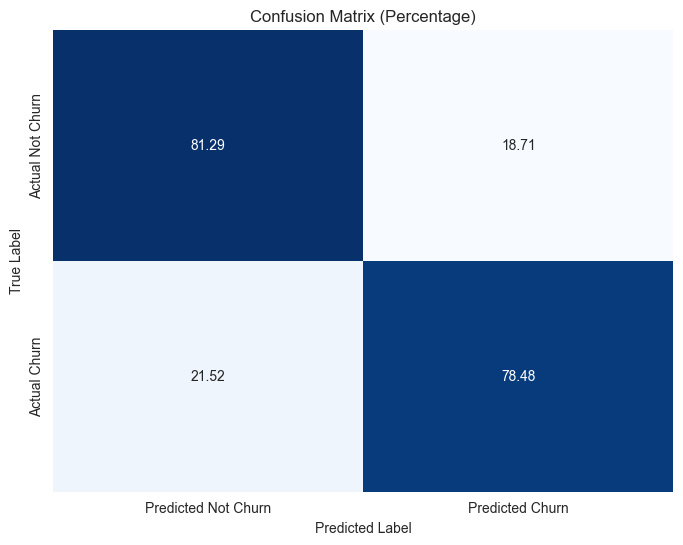

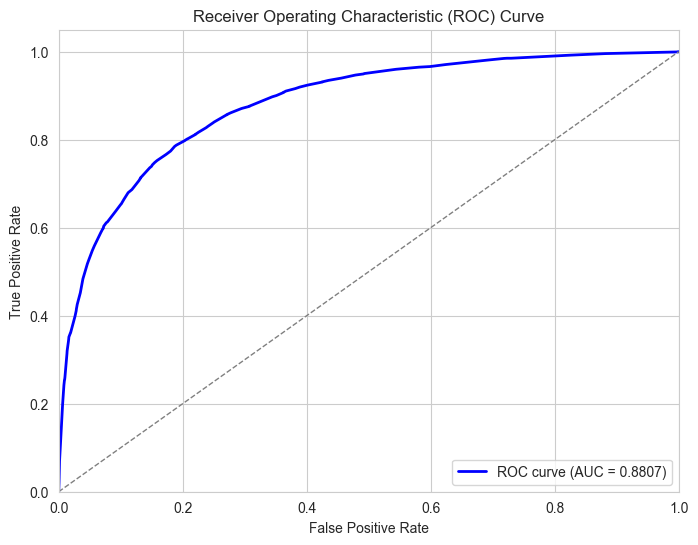

In [14]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}


training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed)) 
])

scoring = {
    'auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

grid_search = GridSearchCV(
    estimator=training_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
model_dectree = best_model

fpr, tpr, auc = evaluate_model(best_model, X_test, y_test)
fpr_dict['Decision Tree'] = fpr
tpr_dict['Decision Tree'] = tpr
auc_dict['Decision Tree'] = auc

# random forest

### baseline

Accuracy: 0.8108280061805072
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     25915
           1       0.54      0.79      0.64      7092

    accuracy                           0.81     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.81      0.82     33007

Precision: 0.5409
Recall: 0.7900
F1 Score: 0.6422
AUC: 0.8864


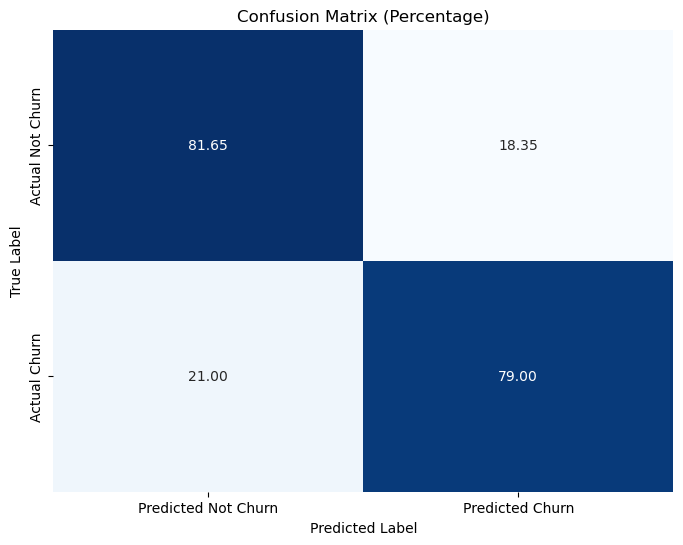

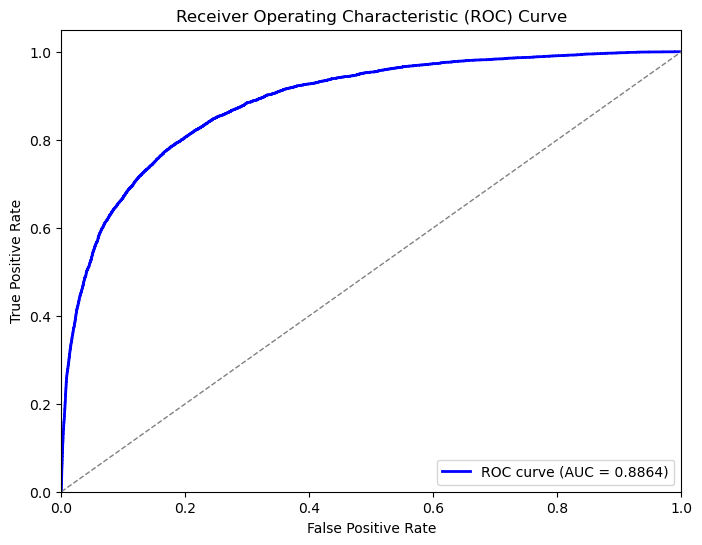

Fold 1:
AUC: 0.8884
Accuracy: 0.8096
Precision: 0.8516
Recall: 0.8096
F1 Score: 0.8217

Fold 2:
AUC: 0.8869
Accuracy: 0.8077
Precision: 0.8516
Recall: 0.8077
F1 Score: 0.8202

Fold 3:
AUC: 0.8877
Accuracy: 0.8081
Precision: 0.8524
Recall: 0.8081
F1 Score: 0.8206

Fold 4:
AUC: 0.8830
Accuracy: 0.8084
Precision: 0.8503
Recall: 0.8084
F1 Score: 0.8206

Fold 5:
AUC: 0.8874
Accuracy: 0.8109
Precision: 0.8524
Recall: 0.8109
F1 Score: 0.8229

mean:
AUC: 0.8867
accuracy: 0.8089
precision: 0.8517
recall: 0.8089
F1 score: 0.8212


In [12]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, max_depth=10, random_state=seed))

training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=seed))  
])

training_pipeline.fit(X_train, y_train)
basemodel_randfor = training_pipeline

fpr, tpr, auc = evaluate_model(training_pipeline, X_test, y_test)
fpr_dict_base['Random Forest'] = fpr
tpr_dict_base['Random Forest'] = tpr
auc_dict_base['Random Forest'] = auc

perform_x_validation(training_pipeline)

### hyperparameter tuning

Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 1000}
Accuracy: 0.8116763110855273
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     25915
           1       0.54      0.79      0.64      7092

    accuracy                           0.81     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.81      0.82     33007

Precision: 0.5424
Recall: 0.7908
F1 Score: 0.6434
AUC: 0.8867


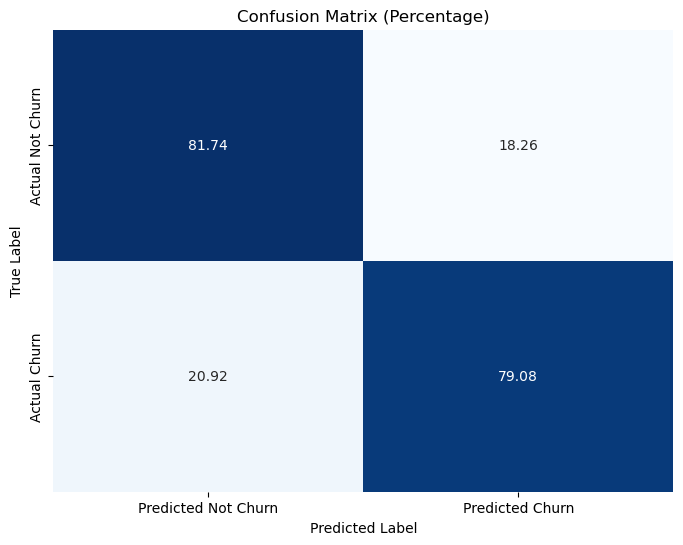

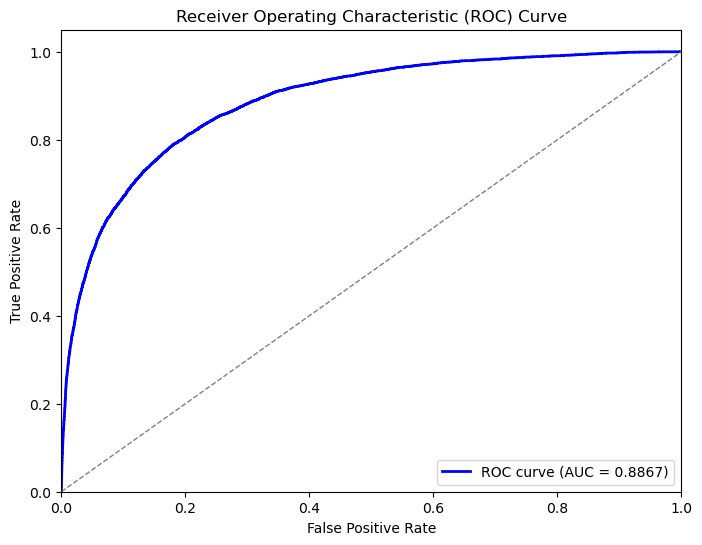

In [13]:
param_grid = {
    'classifier__n_estimators': [1000],
    'classifier__max_depth': [10]
}

training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', RandomForestClassifier(random_state=seed))  
])

scoring = {
    'auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}


grid_search = GridSearchCV(
    estimator=training_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
model_randfor = best_model

fpr, tpr, auc = evaluate_model(best_model, X_test, y_test)
fpr_dict['Random Forest'] = fpr
tpr_dict['Random Forest'] = tpr
auc_dict['Random Forest'] = auc

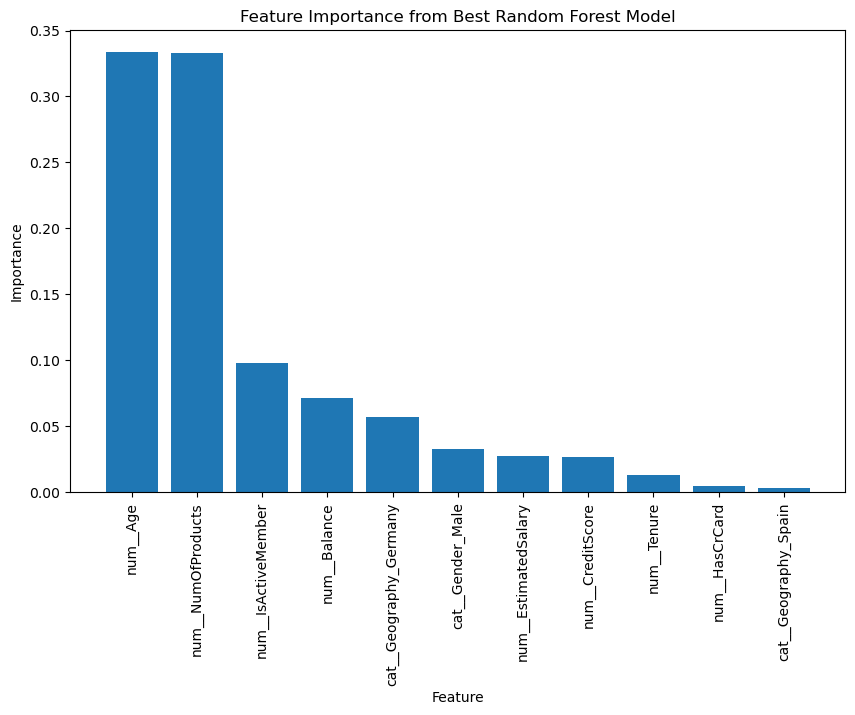

In [ ]:
best_classifier = best_model.named_steps['classifier']
feature_importance = best_classifier.feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
sorted_idx = np.argsort(feature_importance)[::-1]
feature_names_sorted = np.array(feature_names)[sorted_idx[:len(feature_names)]]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names_sorted)), feature_importance[sorted_idx[:len(feature_names)]], align='center')
plt.xticks(range(len(feature_names_sorted)), feature_names_sorted, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance from Best Random Forest Model")
plt.show()

# lightgbm

### baseline

Accuracy: 0.813221437876814
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     25915
           1       0.55      0.79      0.64      7092

    accuracy                           0.81     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.81      0.82     33007

Precision: 0.5452
Recall: 0.7889
F1 Score: 0.6448
AUC: 0.8876


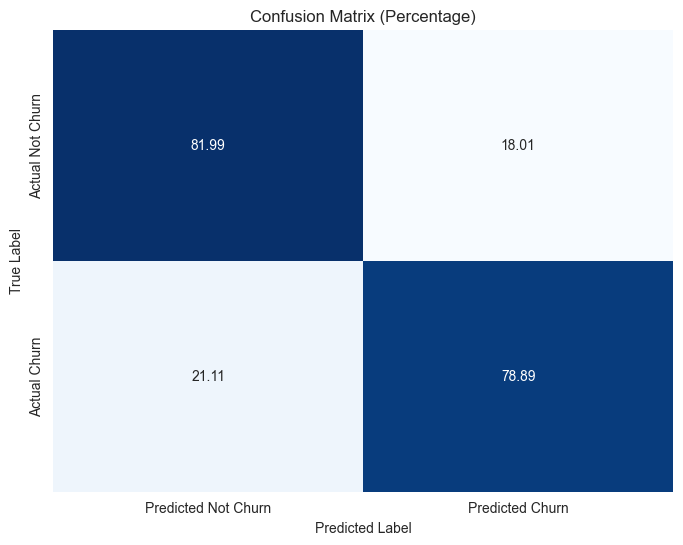

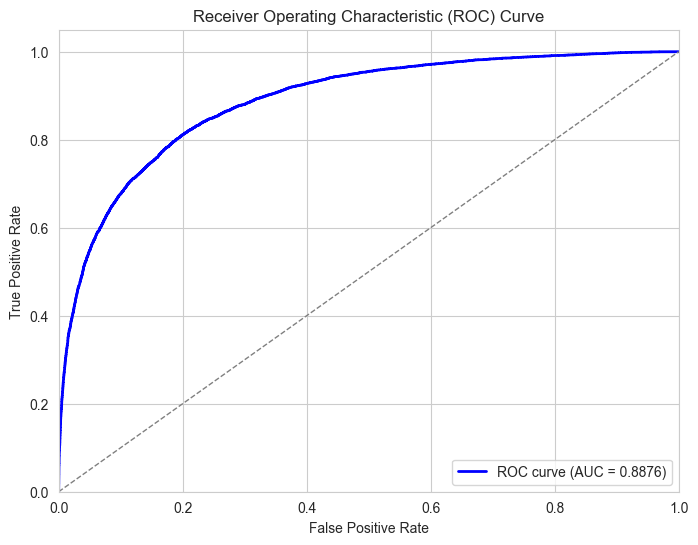

Fold 1:
AUC: 0.8879
Accuracy: 0.8116
Precision: 0.8508
Recall: 0.8116
F1 Score: 0.8232

Fold 2:
AUC: 0.8871
Accuracy: 0.8096
Precision: 0.8511
Recall: 0.8096
F1 Score: 0.8216

Fold 3:
AUC: 0.8887
Accuracy: 0.8117
Precision: 0.8525
Recall: 0.8117
F1 Score: 0.8235

Fold 4:
AUC: 0.8830
Accuracy: 0.8083
Precision: 0.8499
Recall: 0.8083
F1 Score: 0.8204

Fold 5:
AUC: 0.8882
Accuracy: 0.8115
Precision: 0.8531
Recall: 0.8115
F1 Score: 0.8235

mean:
AUC: 0.8870
accuracy: 0.8105
precision: 0.8515
recall: 0.8105
F1 score: 0.8224


In [17]:
training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', LGBMClassifier(n_estimators=200, max_depth=10, random_state=seed, verbose=-1))  
])

training_pipeline.fit(X_train, y_train)
basemodel_lightgbm = training_pipeline

fpr, tpr, auc = evaluate_model(training_pipeline, X_test, y_test)
fpr_dict_base['LightGBM'] = fpr
tpr_dict_base['LightGBM'] = tpr
auc_dict_base['LightGBM'] = auc

perform_x_validation(training_pipeline)

### hyperparameter tuning

Best Hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 500, 'classifier__num_leaves': 30}
Accuracy: 0.8174023691944133
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     25915
           1       0.55      0.78      0.65      7092

    accuracy                           0.82     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.82      0.83     33007

Precision: 0.5531
Recall: 0.7827
F1 Score: 0.6481
AUC: 0.8884


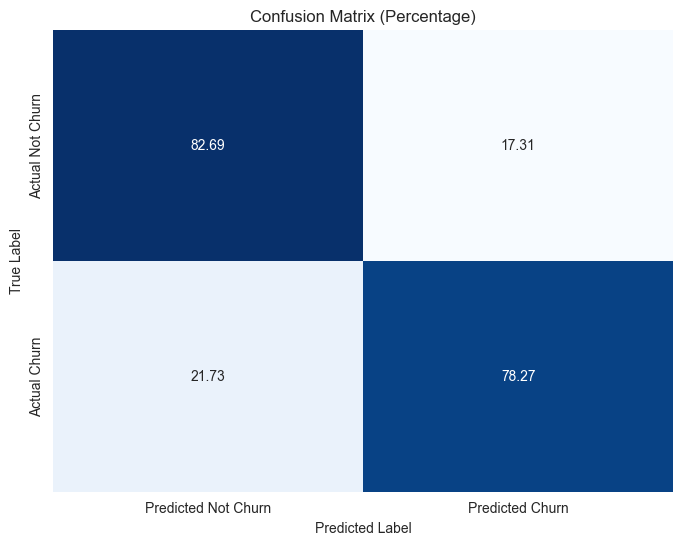

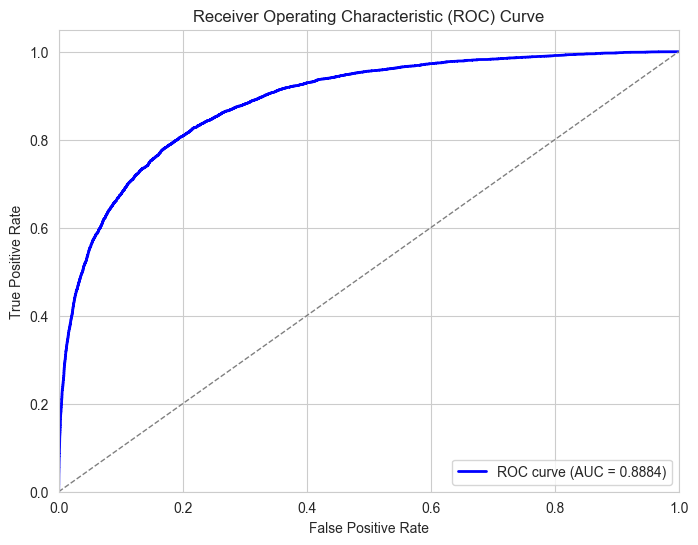

In [18]:
param_grid = {
    'classifier__n_estimators': [500, 700],
    'classifier__learning_rate': [0.1, 0.01],     
    'classifier__max_depth': [3, 7],         
    'classifier__num_leaves': [30, 100],     
}


training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', LGBMClassifier(random_state=seed, verbose=-1))  
])

scoring = {
    'auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}


grid_search = GridSearchCV(
    estimator=training_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
model_lightgbm = best_model

fpr, tpr, auc = evaluate_model(best_model, X_test, y_test)
fpr_dict['LightGBM'] = fpr
tpr_dict['LightGBM'] = tpr
auc_dict['LightGBM'] = auc

# xgboost

### baseline

Accuracy: 0.8092525827854697
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     25915
           1       0.54      0.79      0.64      7092

    accuracy                           0.81     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.81      0.82     33007

Precision: 0.5382
Recall: 0.7908
F1 Score: 0.6405
AUC: 0.8843


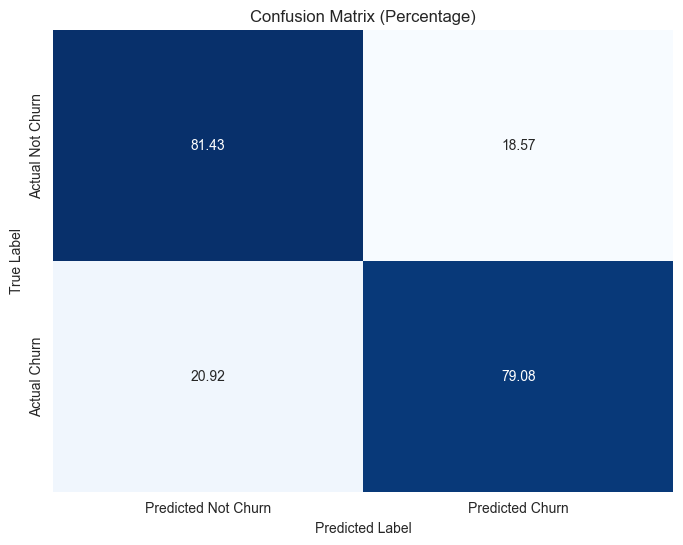

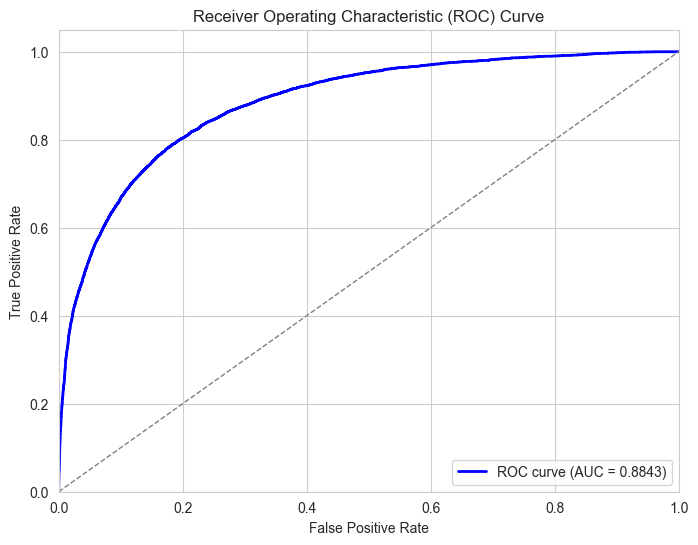

Fold 1:
AUC: 0.8826
Accuracy: 0.8031
Precision: 0.8478
Recall: 0.8031
F1 Score: 0.8160

Fold 2:
AUC: 0.8822
Accuracy: 0.8028
Precision: 0.8487
Recall: 0.8028
F1 Score: 0.8158

Fold 3:
AUC: 0.8845
Accuracy: 0.8067
Precision: 0.8508
Recall: 0.8067
F1 Score: 0.8193

Fold 4:
AUC: 0.8794
Accuracy: 0.8030
Precision: 0.8476
Recall: 0.8030
F1 Score: 0.8158

Fold 5:
AUC: 0.8838
Accuracy: 0.8070
Precision: 0.8511
Recall: 0.8070
F1 Score: 0.8196

mean:
AUC: 0.8825
accuracy: 0.8045
precision: 0.8492
recall: 0.8045
F1 score: 0.8173


In [19]:
training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', XGBClassifier(random_state=seed))  
])

training_pipeline.fit(X_train, y_train)
basemodel_xgboost = training_pipeline

fpr, tpr, auc = evaluate_model(training_pipeline, X_test, y_test)
fpr_dict_base['XGBoost'] = fpr
tpr_dict_base['XGBoost'] = tpr
auc_dict_base['XGBoost'] = auc

perform_x_validation(training_pipeline)

### hyperparameter tuning

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'classifier__learning_rate': 0.001, 'classifier__max_depth': 7, 'classifier__n_estimators': 800}
Accuracy: 0.8178871148544248
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     25915
           1       0.55      0.77      0.65      7092

    accuracy                           0.82     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.82      0.83     33007

Precision: 0.5548
Recall: 0.7721
F1 Score: 0.6456
AUC: 0.8851


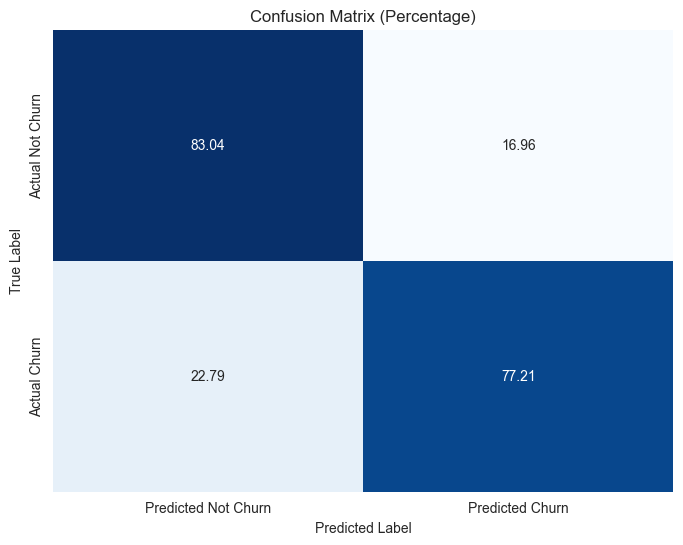

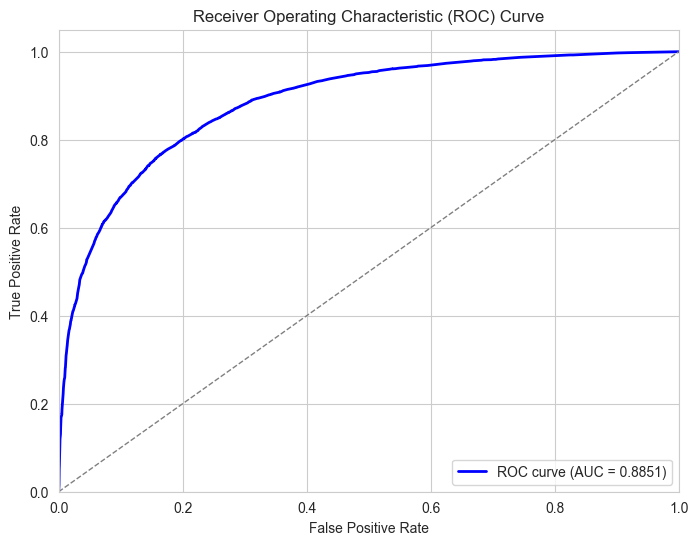

In [ ]:
param_grid = {
    'classifier__n_estimators': [500, 800, 900],
    'classifier__learning_rate': [0.01, 0.1, 0.001],
    'classifier__max_depth': [7, 9],
}

training_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=seed)),
    ('classifier', XGBClassifier(random_state=seed))  
])

scoring = {
    'auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

grid_search = GridSearchCV(
    estimator=training_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
model_xgboost = best_model

fpr, tpr, auc = evaluate_model(best_model, X_test, y_test)
fpr_dict['XGBoost'] = fpr
tpr_dict['XGBoost'] = tpr
auc_dict['XGBoost'] = auc

# neural network

### baseline

In [51]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
# Preprocess data specifically for NN
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(columns=['id', 'CustomerId', 'Surname', 'Exited']),
    df_train['Exited'],
    test_size=0.2,
    random_state=42
)

num_features = X_train.select_dtypes(include=['int64', 'float64', 'boolean']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [53]:
import torch

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [54]:
# Define model architecture

import torch.nn as nn
torch.manual_seed(42)

num_input = 11
num_output = 1

model = nn.Sequential(
    nn.Linear(num_input, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, num_output),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=11, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=1, bias=True)
  (7): Sigmoid()
)


In [55]:
import torch.optim as optim

learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# Training loop
n_epochs = 20
batch_size = 10

epoch_loss = []
for epoch in range(n_epochs):
    total_loss = 0
    total_batches = 0

    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i : i + batch_size]
        y_batch = y_train[i : i + batch_size]
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    # Calculate epoch average loss for graphing
    avg_loss = total_loss / total_batches
    epoch_loss.append(avg_loss)

    print(f"Epoch {epoch + 1}: avg loss {avg_loss}")

Epoch 1: avg loss 0.3438209791642436
Epoch 2: avg loss 0.3274116558415345
Epoch 3: avg loss 0.32589890948902145
Epoch 4: avg loss 0.325118098718213
Epoch 5: avg loss 0.32471464781142395
Epoch 6: avg loss 0.32427848087732203
Epoch 7: avg loss 0.3239842182981677
Epoch 8: avg loss 0.3237649281328994
Epoch 9: avg loss 0.3235512756021138
Epoch 10: avg loss 0.3233801846310698
Epoch 11: avg loss 0.3232543504658878
Epoch 12: avg loss 0.32308061980726815
Epoch 13: avg loss 0.3229033055582015
Epoch 14: avg loss 0.32273902454295883
Epoch 15: avg loss 0.32257999441637436
Epoch 16: avg loss 0.32246078361941133
Epoch 17: avg loss 0.3223873991189092
Epoch 18: avg loss 0.3223171523559647
Epoch 19: avg loss 0.32214079386859595
Epoch 20: avg loss 0.32207402297333226


In [ ]:
def evaluate_model_NN(model, X_test, y_test, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        y_pred_proba = model(X_test).squeeze().cpu().numpy()
        y_pred_custom = (y_pred_proba >= threshold).astype(int) 
    
    # Convert y_test to NumPy if it's a tensor
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()
    
    print("Accuracy:", accuracy_score(y_test, y_pred_custom))
    print(classification_report(y_test, y_pred_custom))

    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    auc = roc_auc_score(y_test, y_pred_proba)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred_custom)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Not Churn', 'Predicted Churn'], 
                yticklabels=['Actual Not Churn', 'Actual Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

    return fpr, tpr, auc

Accuracy: 0.8647256642530372
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     26052
         1.0       0.76      0.53      0.62      6955

    accuracy                           0.86     33007
   macro avg       0.82      0.74      0.77     33007
weighted avg       0.86      0.86      0.86     33007

Precision: 0.7554
Recall: 0.5294
F1 Score: 0.6225
AUC: 0.8885


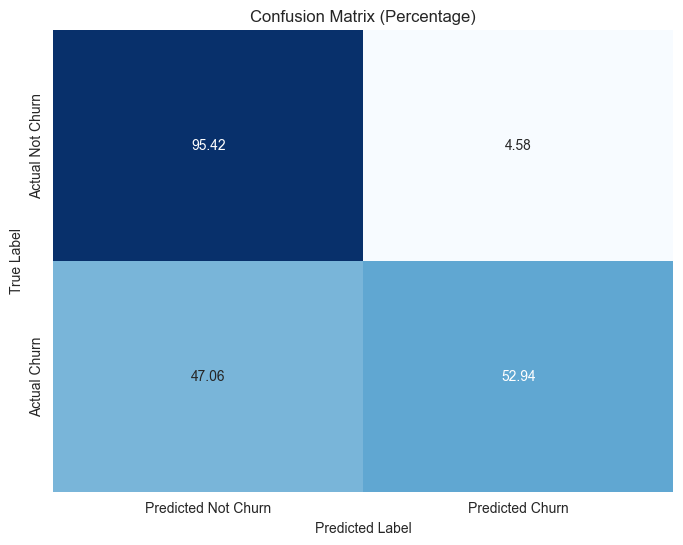

In [57]:
fpr_base, tpr_base, auc_base = evaluate_model_NN(model, X_test, y_test)
fpr_dict_base['Neural Network'] = fpr_base
tpr_dict_base['Neural Network'] = tpr_base
auc_dict_base['Neural Network'] = auc_base

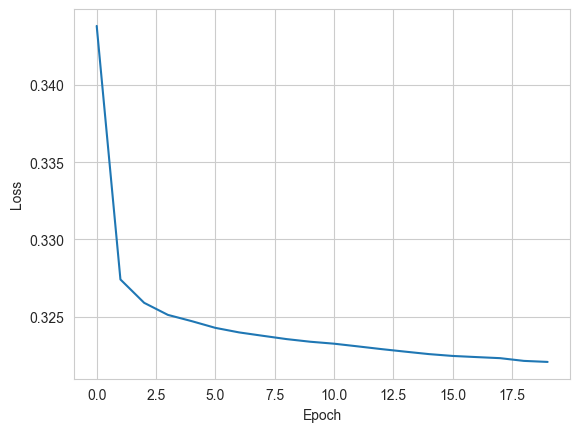

In [58]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### hyperparameter tuning

Testing 10 epochs with batch size 10
Epoch 1: avg loss 0.3438
Epoch 2: avg loss 0.3274
Epoch 3: avg loss 0.3259
Epoch 4: avg loss 0.3251
Epoch 5: avg loss 0.3247
Epoch 6: avg loss 0.3243
Epoch 7: avg loss 0.3240
Epoch 8: avg loss 0.3238
Epoch 9: avg loss 0.3236
Epoch 10: avg loss 0.3234
Evaluating model...

Accuracy: 0.8654830793468052
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     26052
         1.0       0.76      0.53      0.62      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.74      0.77     33007
weighted avg       0.86      0.87      0.86     33007

Precision: 0.7574
Recall: 0.5320
F1 Score: 0.6250
AUC: 0.8885


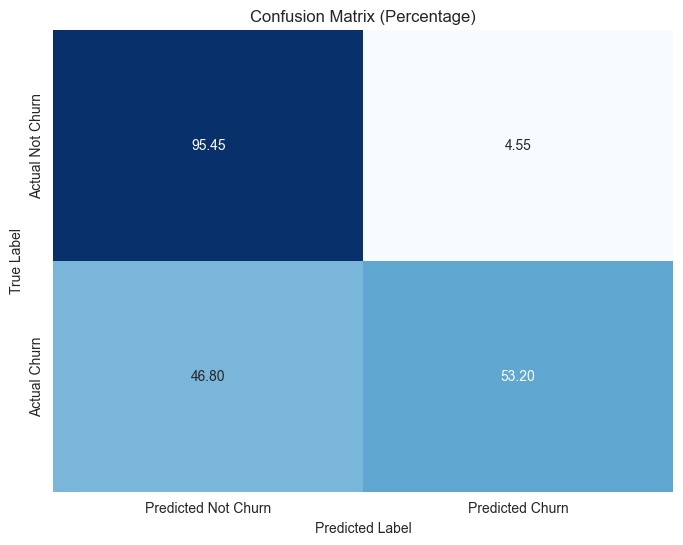

Testing 20 epochs with batch size 10
Epoch 1: avg loss 0.3438
Epoch 2: avg loss 0.3274
Epoch 3: avg loss 0.3259
Epoch 4: avg loss 0.3251
Epoch 5: avg loss 0.3247
Epoch 6: avg loss 0.3243
Epoch 7: avg loss 0.3240
Epoch 8: avg loss 0.3238
Epoch 9: avg loss 0.3236
Epoch 10: avg loss 0.3234
Epoch 11: avg loss 0.3233
Epoch 12: avg loss 0.3231
Epoch 13: avg loss 0.3229
Epoch 14: avg loss 0.3227
Epoch 15: avg loss 0.3226
Epoch 16: avg loss 0.3225
Epoch 17: avg loss 0.3224
Epoch 18: avg loss 0.3223
Epoch 19: avg loss 0.3221
Epoch 20: avg loss 0.3221
Evaluating model...

Accuracy: 0.8647256642530372
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     26052
         1.0       0.76      0.53      0.62      6955

    accuracy                           0.86     33007
   macro avg       0.82      0.74      0.77     33007
weighted avg       0.86      0.86      0.86     33007

Precision: 0.7554
Recall: 0.5294
F1 Score: 0.6225
AUC: 0.8885


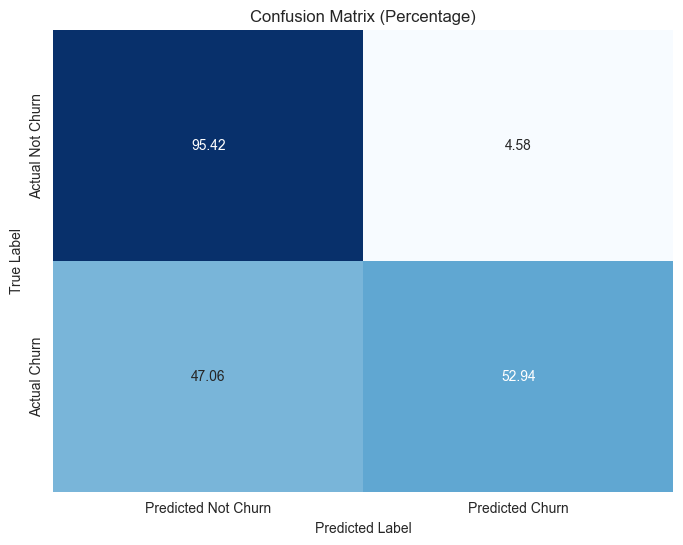

Testing 30 epochs with batch size 10
Epoch 1: avg loss 0.3438
Epoch 2: avg loss 0.3274
Epoch 3: avg loss 0.3259
Epoch 4: avg loss 0.3251
Epoch 5: avg loss 0.3247
Epoch 6: avg loss 0.3243
Epoch 7: avg loss 0.3240
Epoch 8: avg loss 0.3238
Epoch 9: avg loss 0.3236
Epoch 10: avg loss 0.3234
Epoch 11: avg loss 0.3233
Epoch 12: avg loss 0.3231
Epoch 13: avg loss 0.3229
Epoch 14: avg loss 0.3227
Epoch 15: avg loss 0.3226
Epoch 16: avg loss 0.3225
Epoch 17: avg loss 0.3224
Epoch 18: avg loss 0.3223
Epoch 19: avg loss 0.3221
Epoch 20: avg loss 0.3221
Epoch 21: avg loss 0.3220
Epoch 22: avg loss 0.3220
Epoch 23: avg loss 0.3218
Epoch 24: avg loss 0.3218
Epoch 25: avg loss 0.3216
Epoch 26: avg loss 0.3216
Epoch 27: avg loss 0.3215
Epoch 28: avg loss 0.3214
Epoch 29: avg loss 0.3214
Epoch 30: avg loss 0.3213
Evaluating model...

Accuracy: 0.8643924016117793
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     26052
         1.0       0.75      0.53

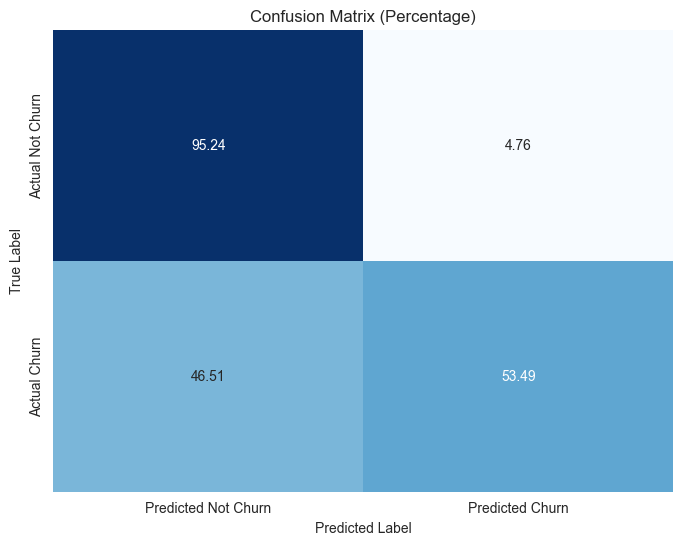

In [ ]:
# Function to test different numbers of epochs
def test_epochs(epoch_values, batch_size=10):
    results = {}

    for n_epochs in epoch_values:
        print(f"Testing {n_epochs} epochs with batch size {batch_size}")

        torch.manual_seed(42)
        model = torch.nn.Sequential(
            torch.nn.Linear(11, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Sigmoid()
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.BCELoss()

        # Train the model
        for epoch in range(n_epochs):
            total_loss = 0
            total_batches = 0

            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i : i + batch_size]
                y_batch = y_train[i : i + batch_size]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_batches += 1

            avg_loss = total_loss / total_batches
            print(f"Epoch {epoch + 1}: avg loss {avg_loss:.4f}")

        print("Evaluating model...\n")
        evaluate_model_NN(model, X_test, y_test)
        results[n_epochs] = model

    return results

epoch_results = test_epochs([10, 20, 30])

Testing batch size 8 with 10 epochs
Epoch 1: avg loss 0.3429
Epoch 2: avg loss 0.3273
Epoch 3: avg loss 0.3262
Epoch 4: avg loss 0.3255
Epoch 5: avg loss 0.3250
Epoch 6: avg loss 0.3246
Epoch 7: avg loss 0.3242
Epoch 8: avg loss 0.3240
Epoch 9: avg loss 0.3237
Epoch 10: avg loss 0.3235
Evaluating model...

Accuracy: 0.8643621050080286
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     26052
         1.0       0.76      0.52      0.62      6955

    accuracy                           0.86     33007
   macro avg       0.82      0.74      0.77     33007
weighted avg       0.86      0.86      0.85     33007

Precision: 0.7587
Recall: 0.5225
F1 Score: 0.6188
AUC: 0.8886


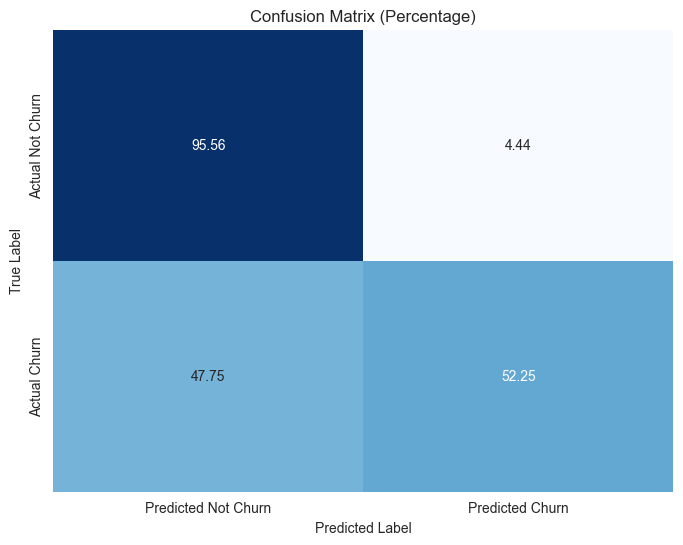

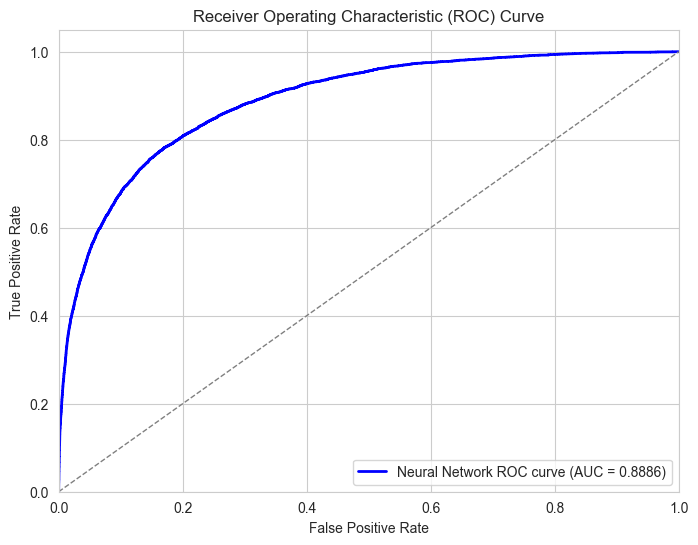

Testing batch size 16 with 10 epochs
Epoch 1: avg loss 0.3455
Epoch 2: avg loss 0.3268
Epoch 3: avg loss 0.3254
Epoch 4: avg loss 0.3247
Epoch 5: avg loss 0.3242
Epoch 6: avg loss 0.3239
Epoch 7: avg loss 0.3236
Epoch 8: avg loss 0.3233
Epoch 9: avg loss 0.3232
Epoch 10: avg loss 0.3230
Evaluating model...

Accuracy: 0.8650286302905444
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     26052
         1.0       0.76      0.52      0.62      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.74      0.77     33007
weighted avg       0.86      0.87      0.85     33007

Precision: 0.7649
Recall: 0.5189
F1 Score: 0.6184
AUC: 0.8888


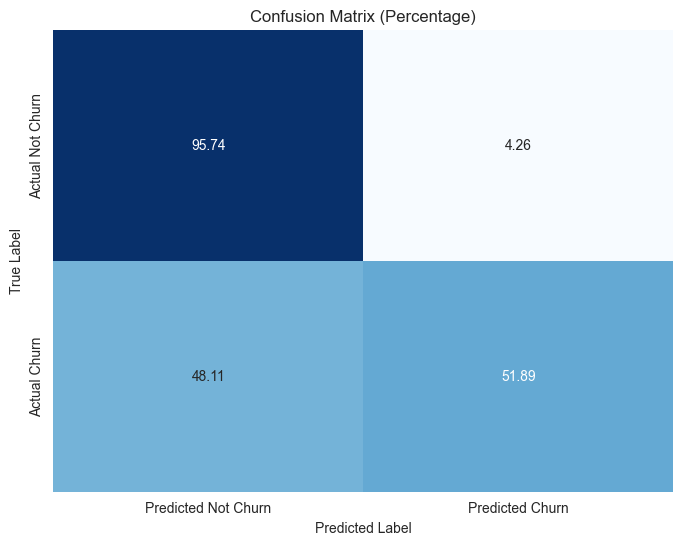

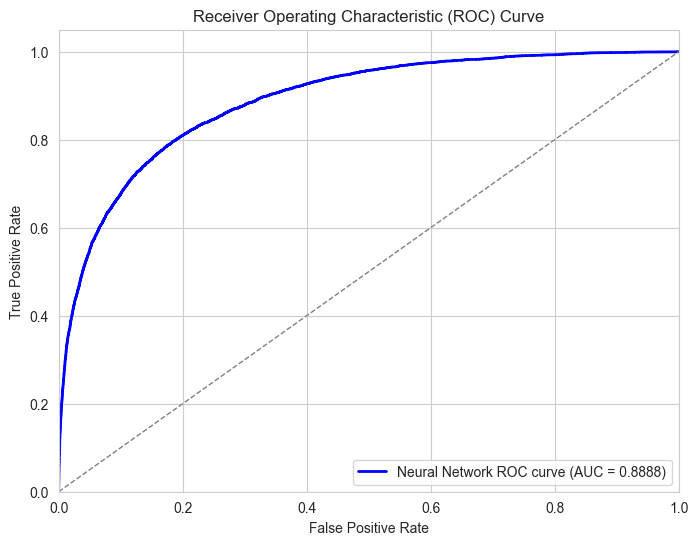

Testing batch size 32 with 10 epochs
Epoch 1: avg loss 0.3524
Epoch 2: avg loss 0.3272
Epoch 3: avg loss 0.3251
Epoch 4: avg loss 0.3244
Epoch 5: avg loss 0.3240
Epoch 6: avg loss 0.3236
Epoch 7: avg loss 0.3234
Epoch 8: avg loss 0.3231
Epoch 9: avg loss 0.3229
Epoch 10: avg loss 0.3227
Evaluating model...

Accuracy: 0.8642712151967764
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     26052
         1.0       0.77      0.50      0.61      6955

    accuracy                           0.86     33007
   macro avg       0.83      0.73      0.76     33007
weighted avg       0.86      0.86      0.85     33007

Precision: 0.7720
Recall: 0.5050
F1 Score: 0.6106
AUC: 0.8893


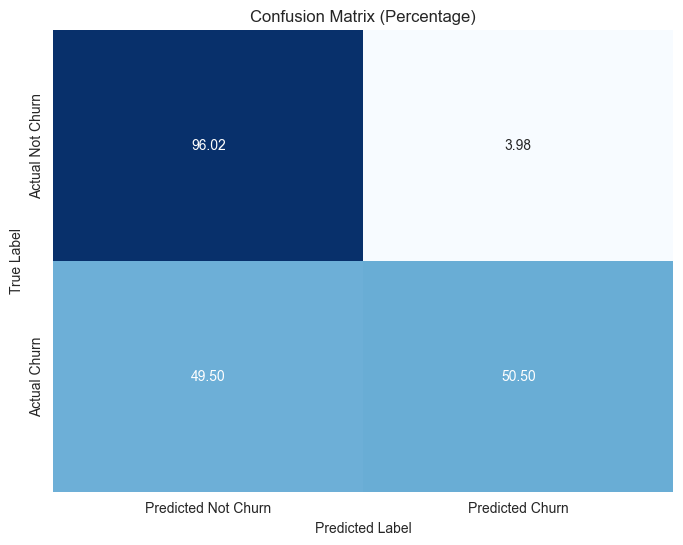

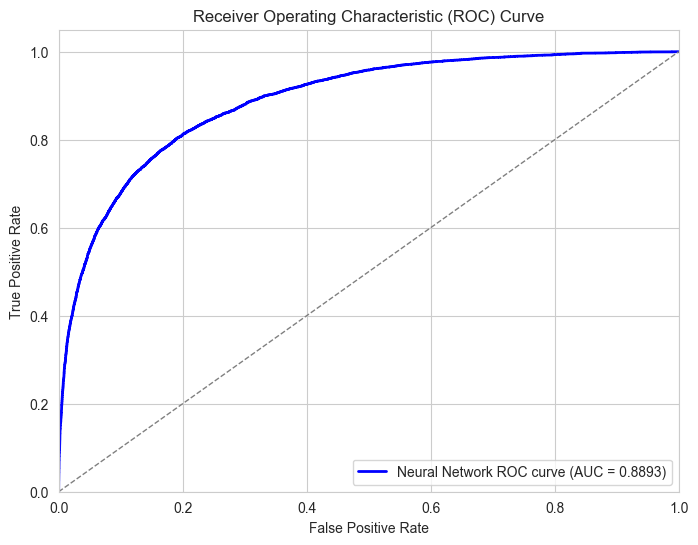

In [ ]:
def test_batch_sizes(batch_size_values, n_epochs=10):
    results = {}

    for batch_size in batch_size_values:
        print(f"Testing batch size {batch_size} with {n_epochs} epochs")

        torch.manual_seed(42)
        model = torch.nn.Sequential(
            torch.nn.Linear(11, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Sigmoid()
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.BCELoss()

        for epoch in range(n_epochs):
            total_loss = 0
            total_batches = 0

            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i : i + batch_size]
                y_batch = y_train[i : i + batch_size]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_batches += 1

            avg_loss = total_loss / total_batches
            print(f"Epoch {epoch + 1}: avg loss {avg_loss:.4f}")

        print("Evaluating model...\n")
        fpr, tpr, auc = evaluate_model_NN(model, X_test, y_test)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'Neural Network ROC curve (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        results[batch_size] = model

    return results, fpr, tpr, auc

batch_size_results, fpr, tpr, auc = test_batch_sizes([8, 16, 32])
fpr_dict['Neural Network'] = fpr
tpr_dict['Neural Network'] = tpr
auc_dict['Neural Network'] = auc

# AUC Curves

In [ ]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost'] 
colors = ['blue', 'green', 'red', 'purple', 'orange']

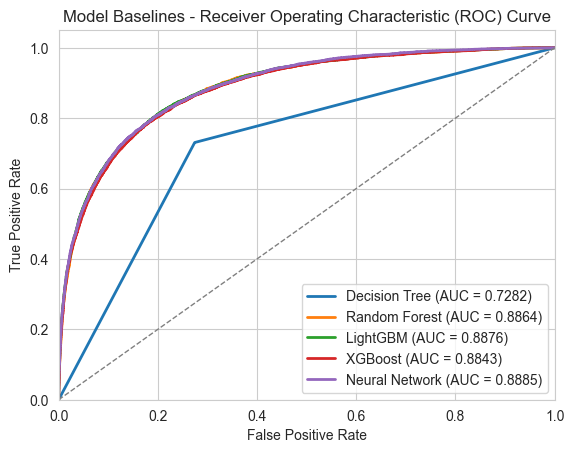

In [ ]:
for model_name in fpr_dict_base:
    if model_name != "Logistic Regression":
        fpr = fpr_dict_base[model_name]
        tpr = tpr_dict_base[model_name]
        auc = auc_dict_base[model_name]
    
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Baselines - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

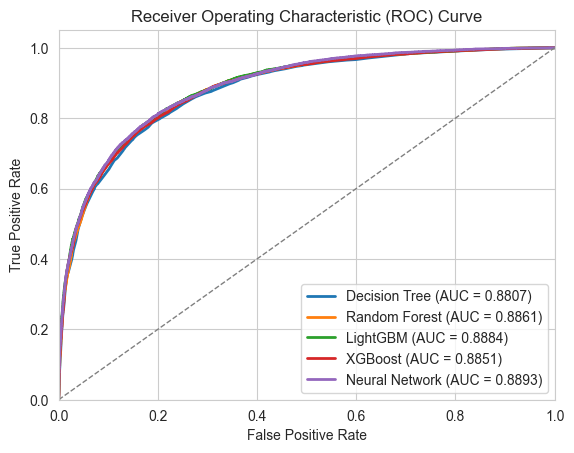

In [66]:
for model_name in fpr_dict:

    if model_name != "Logistic Regression":
        fpr = fpr_dict[model_name]
        tpr = tpr_dict[model_name]
        auc = auc_dict[model_name]
        
        # Plot the ROC curve for the current model
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

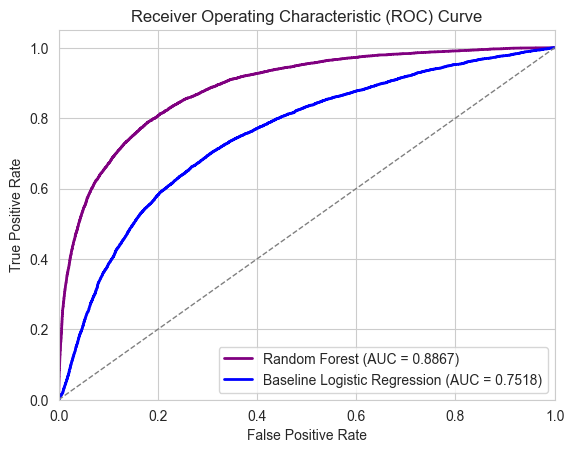

In [ ]:
for model_name in fpr_dict:

    if model_name == "Logistic Regression" or model_name == "Random Forest":
        if model_name == "Logistic Regression":
            fpr = fpr_dict_base[model_name]
            tpr = tpr_dict_base[model_name]
            auc = auc_dict_base[model_name]
             
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'Baseline {model_name} (AUC = {auc:.4f})')
        else: 
            fpr = fpr_dict[model_name]
            tpr = tpr_dict[model_name]
            auc = auc_dict[model_name]
            plt.plot(fpr, tpr, color='purple', lw=2, label=f'{model_name} (AUC = {auc:.4f})')


plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_model_AUC(model_name):    
    fpr = fpr_dict_base[model_name]
    tpr = tpr_dict_base[model_name]
    auc = auc_dict_base[model_name]
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} Baseline (AUC = {auc:.4f})')
    fpr = fpr_dict[model_name]
    tpr = tpr_dict[model_name]
    auc = auc_dict[model_name]
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

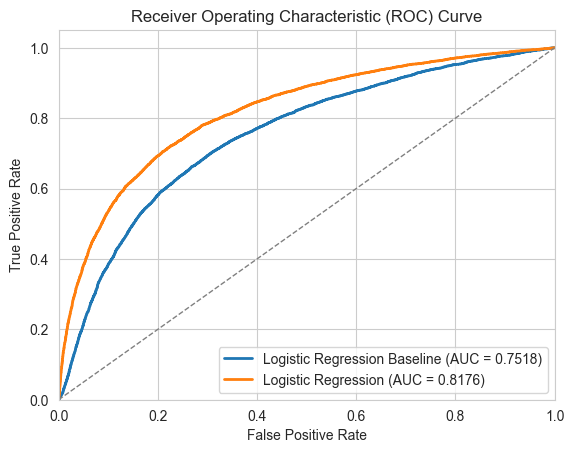

In [36]:
plot_model_AUC("Logistic Regression")

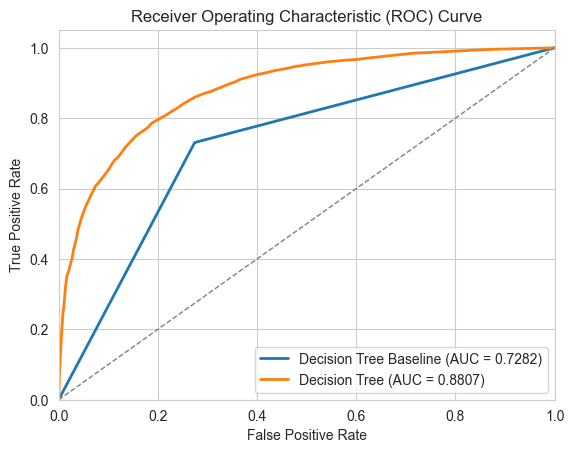

In [37]:
plot_model_AUC("Decision Tree")

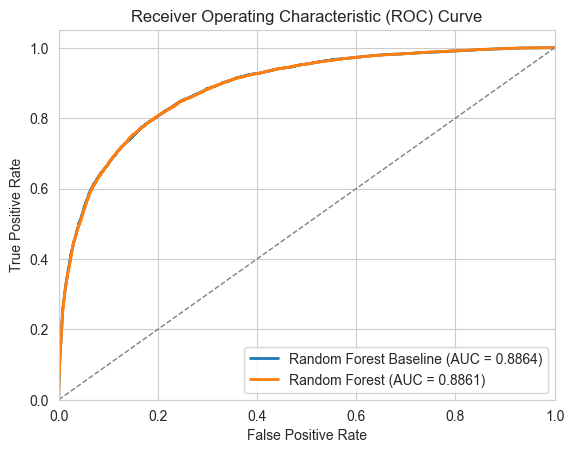

In [38]:
plot_model_AUC("Random Forest")

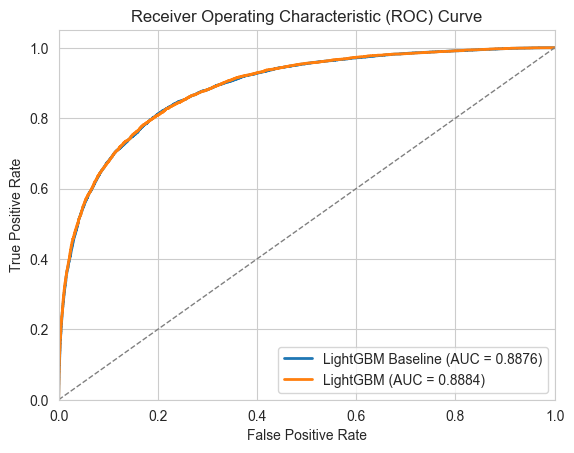

In [39]:
plot_model_AUC("LightGBM")

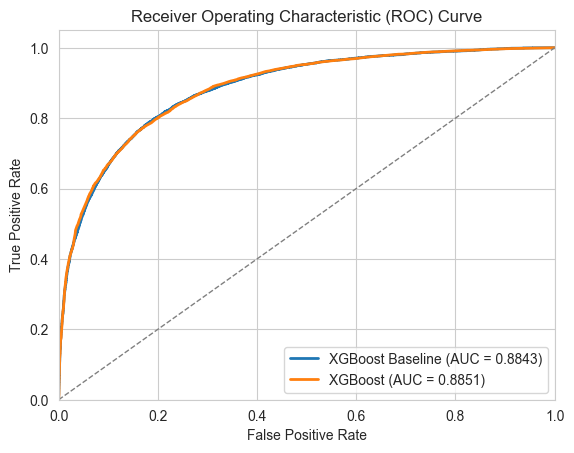

In [40]:
plot_model_AUC("XGBoost")